# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импортируем все нужные библиотеки

In [1]:
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
display(data.head())
display(data.describe())
display(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","9,091.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.89",1.53,0.71,0.52,"100,090.24",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.89,"62,397.41",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,2.00,0.00,1.00,0.00,0.00,"51,002.11",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.54",1.00,1.00,1.00,"100,193.91",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,644.24",2.00,1.00,1.00,"149,388.25",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.09",4.00,1.00,1.00,"199,992.48",1.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

***Вывод***

Проблемы в столбцах с предоплагаемой заработной платой,балансом и пропуски в количестве лет, пол нужно перевести в формат (1,0)
Перевести названия столбцов нижний регистр

In [4]:
data = data.rename(str.lower, axis='columns')
data['balance'] = data['balance'].astype('int64')
data['estimatedsalary'] = data['estimatedsalary'].astype('int64')
#data['tenure'] = data['tenure'].astype('int64')

In [5]:
data.corr()#сильной связи между данными в столбцах нет


,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
rownumber,1.00,0.00,0.01,0.00,-0.01,-0.01,0.01,0.00,0.01,-0.01,-0.02
customerid,0.00,1.00,0.01,0.01,-0.02,-0.01,0.02,-0.01,0.00,0.02,-0.01
creditscore,0.01,0.01,1.00,-0.00,-0.00,0.01,0.01,-0.01,0.03,-0.00,-0.03
age,0.00,0.01,-0.00,1.00,-0.01,0.03,-0.03,-0.01,0.09,-0.01,0.29
tenure,-0.01,-0.02,-0.00,-0.01,1.00,-0.01,0.01,0.03,-0.03,0.01,-0.02
balance,-0.01,-0.01,0.01,0.03,-0.01,1.00,-0.30,-0.01,-0.01,0.01,0.12
numofproducts,0.01,0.02,0.01,-0.03,0.01,-0.30,1.00,0.00,0.01,0.01,-0.05
hascrcard,0.00,-0.01,-0.01,-0.01,0.03,-0.01,0.00,1.00,-0.01,-0.01,-0.01
isactivemember,0.01,0.00,0.03,0.09,-0.03,-0.01,0.01,-0.01,1.00,-0.01,-0.16
estimatedsalary,-0.01,0.02,-0.00,-0.01,0.01,0.01,0.01,-0.01,-0.01,1.00,0.01


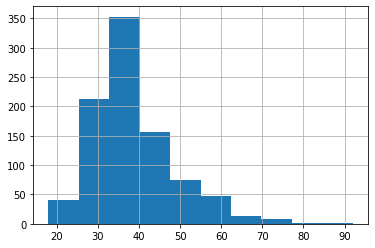

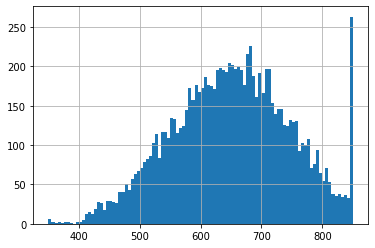

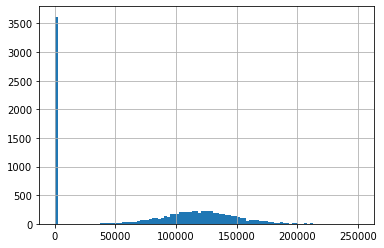

In [6]:
plt.figure()
data[data['tenure'].isnull()]['age'].hist()# 3 страны можно сделать также 
plt.figure()
data['creditscore'].hist(bins = 100)#большое количество людей с максимальным кредитным рейтингом
plt.figure()
data['balance'].hist(bins = 100)#есть большое количество людей с балансом карты 0


In [8]:
display(data.loc[(data['age']==20)]) #&(data['age']<= 30)]#.pivot_table(index = 'age',values = 'tenure', aggfunc = {'mean','median'})
# очень интересно что в столбце Tenure — сколько лет человек является клиентом банка у 20 летних заполнены и 5 и 7 лет
# возможно у них используют детские вклады либо дебетовые карты уже использовали в детском возрасте. Либо это ошибка.
# я не вижу тут связи с возрастом поэтому заполню пропуски медианой
data['tenure'] = data['tenure'].fillna(5)
data['tenure'] = data['tenure'].astype('int64')

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
233,234,15723886,Fiore,767,Germany,Male,20,3.00,119714,2,0,1,150135,0
1064,1065,15699598,Smith,723,France,Female,20,4.00,0,2,1,1,140385,0
1327,1328,15688007,Liu,703,Spain,Male,20,3.00,165260,1,1,1,41626,0
1685,1686,15713826,Ferguson,613,Germany,Female,20,0.00,117356,1,0,0,113557,1
1730,1731,15643438,P'eng,850,France,Male,20,7.00,0,2,1,0,31288,0
1905,1906,15566843,Gotch,535,Germany,Male,20,9.00,134874,1,1,1,118825,0
2250,2251,15739576,Bustard,706,Spain,Male,20,8.00,0,2,1,1,12368,0
2497,2498,15748123,Chienezie,613,France,Male,20,3.00,0,2,1,1,149613,0
2832,2833,15758171,Tien,582,France,Male,20,4.00,0,1,1,1,55763,0
2945,2946,15776348,Rogers,835,Germany,Male,20,4.00,124365,1,0,0,180197,1


In [9]:
display(data.info())
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
rownumber          10000 non-null int64
customerid         10000 non-null int64
surname            10000 non-null object
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null int64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null int64
exited             10000 non-null int64
dtypes: int64(11), object(3)
memory usage: 1.1+ MB


None

,rownumber,customerid,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,"10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00","10,000.00"
mean,"5,000.50","15,690,940.57",650.53,38.92,5.00,"76,485.57",1.53,0.71,0.52,"100,089.75",0.20
std,"2,886.90","71,936.19",96.65,10.49,2.76,"62,397.19",0.58,0.46,0.50,"57,510.49",0.40
min,1.00,"15,565,701.00",350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.00,0.00
25%,"2,500.75","15,628,528.25",584.00,32.00,3.00,0.00,1.00,0.00,0.00,"51,001.75",0.00
50%,"5,000.50","15,690,738.00",652.00,37.00,5.00,"97,198.00",1.00,1.00,1.00,"100,193.50",0.00
75%,"7,500.25","15,753,233.75",718.00,44.00,7.00,"127,643.75",2.00,1.00,1.00,"149,387.75",0.00
max,"10,000.00","15,815,690.00",850.00,92.00,10.00,"250,898.00",4.00,1.00,1.00,"199,992.00",1.00


Нужно преобразовать категориальные признаки в численные с помощью техники прямого кодирования. 
Подготовим данные для анализа выделим обучающую, тестовую и валидационную выборку. 
Выделим признаки и целевой признак. 

In [11]:
data_ml = data.drop(['rownumber','customerid','surname'], axis = 1)#удалим столбцы которые нам не нужны для построение моделей обучения
data_ml = pd.get_dummies(data_ml, drop_first=True)#уберем столбцы,чтобы избежать дамми лавушки
display(data_ml.head())
target = data_ml['exited']#выделим целевой признак
features = data_ml.drop('exited', axis=1)#выделим признаки

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0,1,1,1,101348,1,0,0,0
1,608,41,1,83807,1,0,1,112542,0,0,1,0
2,502,42,8,159660,3,1,0,113931,1,0,0,0
3,699,39,1,0,2,0,0,93826,0,0,0,0
4,850,43,2,125510,1,1,1,79084,0,0,1,0


In [12]:
features_train, features_valid_0, target_train, target_valid_0  = train_test_split(features, target, test_size=0.40, random_state=12345) #  разделите данные на обучающую и валидационную выборки(которую разобьем на валидационную и тестовую выборки)
features_valid, features_test, target_valid, target_test  = train_test_split(features_valid_0, target_valid_0, test_size=0.50, random_state=12345)

In [13]:
target.value_counts()# виден дисбаланс классов, 80/20. Но сначала построим модель без учета баланса

0    7963
1    2037
Name: exited, dtype: int64

In [14]:
target_valid.value_counts(normalize=True)

0   0.79
1   0.21
Name: exited, dtype: float64

In [15]:
sd = [features_train, target_train,features_valid, target_valid,features_test, target_test]

for s in sd:
    display(s.shape)#размеры датасетов остались такими же,ничего не потеряли

(6000, 11)

(6000,)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

***Вывод*** 

Ознакомился с данными, устранил пропуски в данных,перевел названия столбцов в нижний регистр,преобразовал категориальные признаки в численные с помощью техники прямого кодирования. 
Подготовил данные для анализа выделил обучающую, тестовую и валидационную выборку. 
Выделил признаки и целевой признак. 

## Исследование задачи

Построим модель логистической регрессии без учета дисбаланса классов

In [16]:
model = LogisticRegression(random_state = 12345)
model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)

accuracy_valid = model.score(features_valid, target_valid)
display("Accuracy:",accuracy_valid)

display("F1:",f1_score(target_valid, predicted_valid))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


'Accuracy:'

0.7815

'F1:'

0.08385744234800838

In [17]:
x = predicted_valid.sum()/len(predicted_valid)
x

0.0295

In [18]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
display("F1:",f1_score(target_valid, predicted_valid))

'F1:'

0.5036319612590799

In [19]:
model = RandomForestClassifier(random_state=12345, n_estimators= 40,max_depth=9) 
model.fit(features_train,target_train) 
predicted_valid = model.predict(features_valid)
display("F1:",f1_score(target_valid, predicted_valid))

'F1:'

0.5745682888540031

***ВЫВОД***

Модель получает acuuracy 80% за счет того,что она просто чаще всего предсказывает что клиент останется(97,7%) проставляя 0, что в итоге из за сильного дисбаланса классов демонстрирует относительно высокую точность. Такая метрика не рабочая, нужно использовать другие метрики/

Если не работать с дисбалансом классов то лучшая f1 мера получается на модели случайного леса(0,57)

## Борьба с дисбалансом

Посмотрим метрику f1 при взвешивании классов, увеличение выборки, уменьшение выборки. Рассмотрим на модели логистической регрессии как самой быстро наистраиваемой

Взвешивание классов

In [20]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
display("F1:", f1_score(target_valid, predicted_valid))

'F1:'

0.45176848874598063

Увеличение выборки

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state = 12345,solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)


display("F1:", f1_score(target_valid, predicted_valid))

'F1:'

0.4512489927477841

Уменьшение выборки

In [22]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.4)

model = LogisticRegression(random_state = 12345,solver='liblinear')

model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)


display("F1:", f1_score(target_valid, predicted_valid))

'F1:'

0.41570438799076215

Лучшие результаты получились у модели с балансировкой класса ее и будем усовершенствовать


In [23]:
best_indicator = None
best_model = None
best_f1 = 0
best_est = 0
best_depth = 0



for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators= est,max_depth=depth, class_weight='balanced') # обучим модель с заданным количеством деревьев
        model.fit(features_train,target_train) # обучим модель на тренировочной выборке
        predicted_valid = model.predict(features_valid)
        f1 = f1_score(target_valid, predicted_valid) # посчитаем качество модели на валидационной выборке
        if f1 > best_f1:
            best_model = model# сохранм наилучшую модель
            best_f1 = f1#  сохраним наилучшее значение метрики accuracy на валидационных данных
            best_est = est # сохраним лучшее количество дереьвьев в модели
            best_depth = depth
                

                
display("f1 наилучшей модели на валидационной выборке:", best_f1)
display("Наилучшее количество деревьев в модели на валидационной выборке:", best_est)
display("Наилучшая максимальной глубиной на валидационной выборке:", best_depth)



display(best_model)

'f1 наилучшей модели на валидационной выборке:'

0.6348837209302326

'Наилучшее количество деревьев в модели на валидационной выборке:'

40

'Наилучшая максимальной глубиной на валидационной выборке:'

9

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=None, oob_score=False,
                       random_state=12345, verbose=0, warm_start=False)

'F1:'

0.6348837209302326

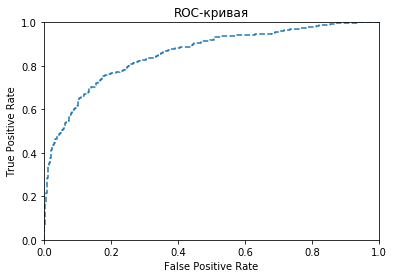

0.8565803083735083

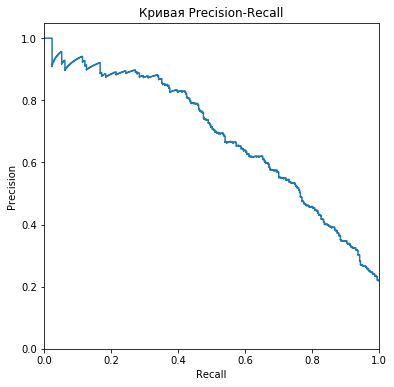

In [27]:
model = RandomForestClassifier(random_state=12345, n_estimators= 40,max_depth=9, class_weight='balanced') 
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
f1 = f1_score(target_valid, predicted_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
display("F1:",f1)

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

display(auc_roc)

precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 


***ВЫВОД:***
***
Выбрали модель с наилучшими результатами это модель случайного леса(с балансировкой классов, 40 деревьями, глубиной леса 9) f1 получился 0,634. НА этой модели и будем проверять на тестовой выборке

## Тестирование модели

'F1:'

0.5904954499494438

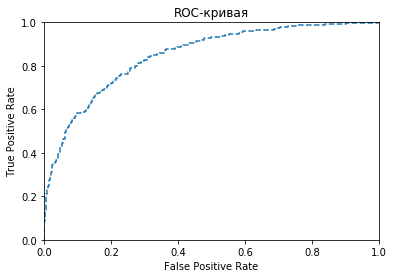

0.8477028682104303

In [25]:
predicted_test = model.predict(features_test)
display("F1:", f1_score(target_test, predicted_test))

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
display(auc_roc)

***Вывод*** 

В данном случае была решена задача классификации. Классы были несбалансированны. Поэтому ранее успользуюмая метрика accuracy не подходила. Для оценки эффективности работы модели использовалась метрика f1 мера. 

Для борьбы с дисбалансом классов были рассмотрены разные варианы: увеличение-уменьшение выборки, балансировка классов.

В итоге лучшие реузльтаты на валидационной выборке показал случайный лес с балансировкой классов

На тестовой выборке модель показала значение f1 хуже, чем на валидационной, но тоже достаточно высокое. Значение auc-roc на тестовой тоже стало немного хуже(было 0.856, стало 0.847)

При балансировке классов метрика f1 лучше,чем без балансировки. Были попытки сделать комбинирование(классы сбалансированы,и увеличение(уменьшение) выборки),но такое комбинирование не дало увеличение f1 меры